In [1]:
import matplotlib.pyplot as plt
import itertools
import hoomd
import math

import xarray as xr
import numpy
import gsd.hoomd
import sphere_fres as sf
import model_tools as mt


In [2]:
N_particles =75
space = 9
arc_angle = math.pi/2
radius = space*(N_particles/arc_angle)
theta = arc_angle/N_particles
L = 1.5*radius
position=[]
for i in range(N_particles):
   position.append([radius*math.sin(theta*i)-radius/2,radius*math.cos(theta*i)-radius/2,0])


orientation = [(1, 0, 0, 0)] * N_particles



# gsd snapshot
snapshot = gsd.hoomd.Frame()
snapshot.particles.N = N_particles
snapshot.particles.position = position
snapshot.particles.orientation = orientation
snapshot.particles.typeid = [0] * N_particles
snapshot.particles.types = ['A']
snapshot.configuration.box = [L, L, L, 0, 0, 0]
with gsd.hoomd.open(name='linear.gsd', mode='w') as f:
    f.append(snapshot)


In [3]:
# build simulation
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=0)
sim.create_state_from_gsd(filename='linear.gsd')

#simulation parameters
initial_kT = 0.01

In [4]:
sx,sz,sy,sa,sb,sc,data_map = mt.get_data("mt_full_new.nc")

patch_param_array = numpy.append(data_map,initial_kT)

In [5]:
mc = hoomd.hpmc.integrate.Sphere(default_d=2, default_a=0.8)
mc.shape['A'] = dict(diameter=2, orientable=True)
sim.operations.integrator = mc


In [6]:
patch_code = mt.patch_code(sx,sz,sy,sa,sb,sc)

In [7]:
patch_potential = hoomd.hpmc.pair.user.CPPPotential(r_cut=10,
                                                    code=patch_code,
                                                    param_array=patch_param_array)

mc.pair_potential = patch_potential
sim.run(0000)
print(patch_potential.energy)

-234284592.0


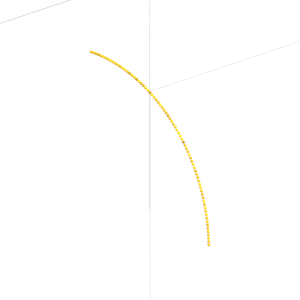

In [8]:
sf.render(sim.state.get_snapshot(),L*1.2)

In [9]:
logger = hoomd.logging.Logger()
logger.add(patch_potential, quantities=[
    'energy',
])
logger[('kT',)] = (lambda: patch_potential.param_array[sx*sz*sy*sa*sb*sc], 'scalar')
gsd_writer = hoomd.write.GSD(filename='log.gsd',
                             trigger=hoomd.trigger.Periodic(10),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             logger=logger)
sim.operations.writers.append(gsd_writer)


In [10]:
sim.run(20000)


In [11]:
gsd_writer.flush()

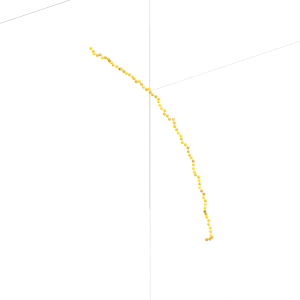

In [12]:
sf.render(sim.state.get_snapshot(),L*1.2)

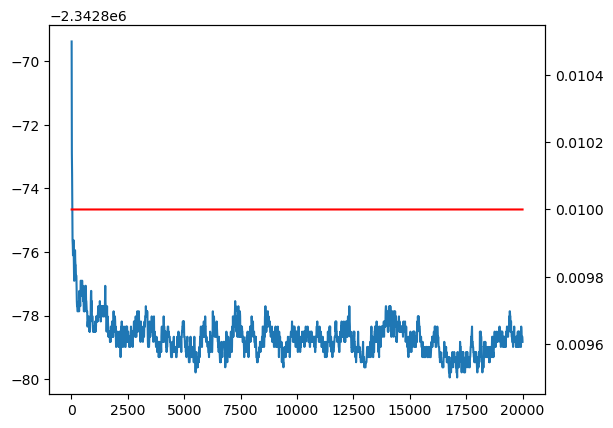

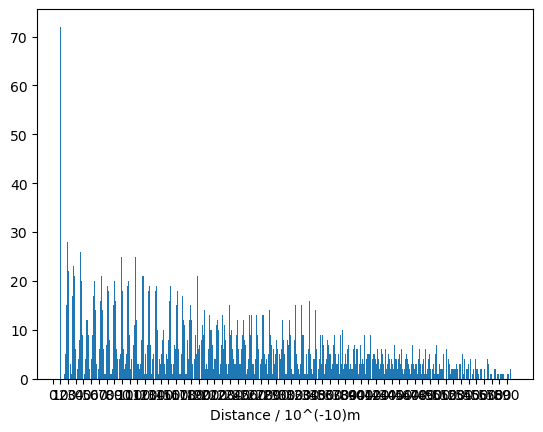

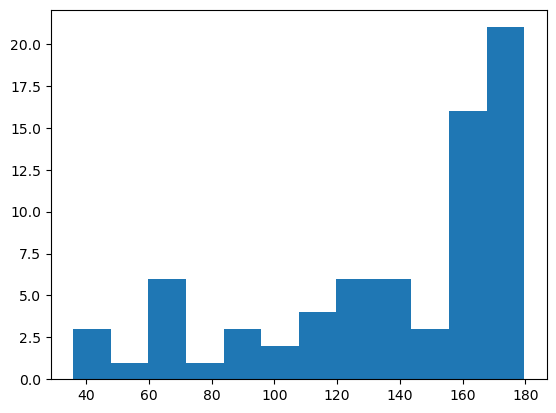

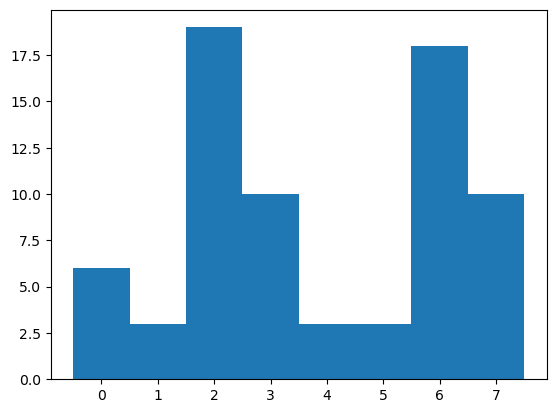

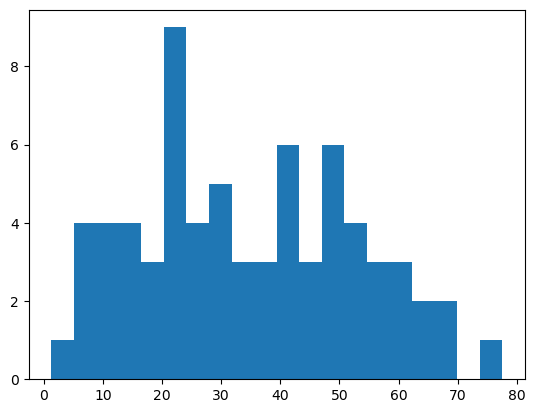

In [13]:
mt.graphs(sim)